Trochę chyba to co w poprzednim tylko actually chcemy więcej kontekstu (WOW)
Chyba jeszcze jakieś tricki z dev testami i testem

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
words = open('names.txt', 'r').read().splitlines()
words[100:103]

['peyton', 'rylee', 'clara']

In [7]:
### BASIC FUNKCJE ###
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [ ]:
# TLDR: 
# Bierzemy indeks słowa (0.16999) zamieniamy na V[30] potem te 3 słowa na V[100] i potem 17000 logits (softmax) na górze (chcemy wiedzieć jakie prawdopodobieństwa)

In [81]:
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
# Każdą literę zamieniamy na 2
C = torch.rand((27,2))

# Można tak o tym myśleć
# C[5] - F.one_hot(torch.tensor(5), num_classes = 27).float() @ C

tensor([0., 0.])

In [15]:
C[[5, 6, 7]] # Works
emb = C[X]

In [32]:
W1 = torch.randn((6, 100)) # wrzucamy 3 x 2, x 100 (hidden layer)
b1 = torch.randn(100)

In [ ]:
#32 by 3 by 2 into 32 by 6
#emb.shape
# To brzydkie, bo well mało skalowlne
# emb2 = torch.cat([emb[:, 0, :],emb[:, 1, :],emb[:, 2, :]], 1)
# emb2.shape

# Tak lepiej
#torch.cat(torch.unbind(emb, 1), 1).shape


#można najlepiej
#a = torch.arange(18)
#a.view(2,9) # WOW
#emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
# Ten plus wyżej działa bo jakby to jest 32 x 100 + 100 no i to broadcasting chill

In [36]:
h.shape

torch.Size([32, 100])

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
logits = h @ W2 + b2

# Cross entropy ale gorzej (może psuć się dla bardzo skrajnych and wolniejsze)
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdim=True)
# loss = -prob[torch.arange(32), Y].log().mean()

loss = F.cross_entropy(logits, Y)

tensor(17.2162)

In [82]:
# Teraz od nowa jak andrej (przepisujemy ładniej)
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator = g)
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)
params = [C, W1, b1, W2, b2]

In [83]:
for p in params:
    p.requires_grad = True

In [ ]:
# To już jest kinda chill code like that (tylko wolne bo na wszystkim)
for _ in range(100):
    print(loss.item())
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)

    #backward
    for p in params:
        p.grad = None
    loss.backward()
    # update
    for p in params:
        p.data -= p.grad * 0.1
print(loss.item())

In [ ]:
# To już jest kinda chill code like that (tylko wolne bo na wszystkim)
for _ in range(100):
    ix = torch.randint(0, X.shape[0], (128,))
    print(loss.item())
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    #backward
    for p in params:
        p.grad = None
    loss.backward()
    # update
    for p in params:
        p.data -= p.grad * 0.02
print(loss.item())

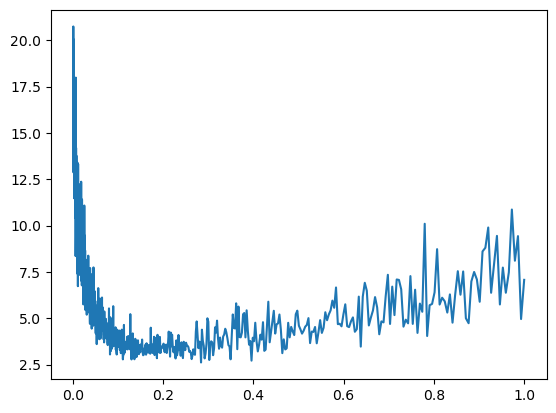

In [107]:
# Musimy znaleźć jakiś learning rate range
lre = torch.linspace(-3, 0, 1000)
# nie chcemy liniowo tylko tak lepiej
lrs = 10**lre
losses = []
rates = []
for rate in lrs:
    
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((27, 2), generator = g)
    W1 = torch.randn((6, 100), generator = g)
    b1 = torch.randn(100, generator = g)
    W2 = torch.randn((100, 27), generator = g)
    b2 = torch.randn(27, generator = g)
    params = [C, W1, b1, W2, b2]
    for p in params:
        p.requires_grad = True
    for _ in range(100):
        ix = torch.randint(0, X.shape[0], (32,))
        emb = C[X[ix]]
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y[ix])

        #backward
        for p in params:
            p.grad = None
        loss.backward()
        # update
        for p in params:
            p.data -= p.grad * rate
    rates.append(rate)
    losses.append(loss.item())
plt.plot(rates, losses)
    

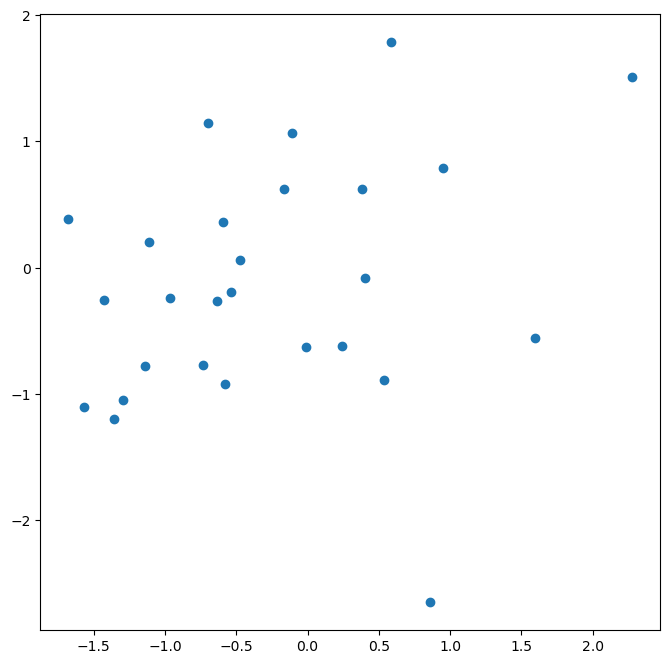

In [ ]:
# Teraz możemy próbować na jednej z tych lepszych coś dłużej
# Ew na koniec zmniejszyć

# Teraz trzeba podzielić, bo inaczej zapamięta
# 80% 10% 10%
# Train dev test

# Jak training i dev bardzo podobne toznacczy, że underfitting (sieć za mała)

# Można zwiększyć hidden layer i to spoko
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data)
# Tu można dodać opis tych punktów

# Ale chyba więcej ma sensu opisać ile ma inputów dana sieć